In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import logging
import warnings
sns.set_style("darkgrid")
logging.getLogger("tensorflow").setLevel(logging.ERROR)
warnings.simplefilter("ignore")

In [2]:
# Set the file and directory paths
sdir = r"C:\Users\ABHIJEET\\Processed Images_Fruits"
bad_path = r"C:\Users\ABHIJEET\Processed Images_Fruits\Bad Quality_Fruits"
good_path = r"C:\Users\ABHIJEET\Processed Images_Fruits\Good Quality_Fruits"
mixed_path = r"C:\Users\ABHIJEET\Processed Images_Fruits\Mixed Qualit_Fruits"

filepaths = []
labels = []
ht = 0
wt = 0
samples = 0
sample_count = 20
for quality in [bad_path, good_path, mixed_path]:
    fruit_list = os.listdir(quality)
    for fruit in fruit_list:
        fruit_path = os.path.join(quality, fruit)
        img_list = os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path = os.path.join(fruit_path, img)
            if i < sample_count:
                img = plt.imread(img_path)
                ht += img.shape[0]
                wt += img.shape[1]
                samples += 1
            filepaths.append(img_path)
            if quality == mixed_path:
                labels.append(fruit + "_mixed")
            else:
                labels.append(fruit)
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)
df 

filepaths             labels
0      C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...          Apple_Bad
1      C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...          Apple_Bad
2      C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...          Apple_Bad
3      C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...          Apple_Bad
4      C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...          Apple_Bad
...                                                  ...                ...
19521  C:\Users\ABHIJEET\Processed Images_Fruits\Mixe...  Pomegranate_mixed
19522  C:\Users\ABHIJEET\Processed Images_Fruits\Mixe...  Pomegranate_mixed
19523  C:\Users\ABHIJEET\Processed Images_Fruits\Mixe...  Pomegranate_mixed
19524  C:\Users\ABHIJEET\Processed Images_Fruits\Mixe...  Pomegranate_mixed
19525  C:\Users\ABHIJEET\Processed Images_Fruits\Mixe...  Pomegranate_mixed

[19526 rows x 2 columns]

In [3]:
# Create a DataFrame from the collected file paths and labels
df = pd.DataFrame({"filepaths": filepaths, "labels": labels})
df['labels'] = df['labels'].astype('category')

# Display value counts and unique labels
print(df['labels'].value_counts())
print(df['labels'].unique())


Pomegranate_Good     5940
Orange_Good          1216
Pomegranate_Bad      1187
Orange_Bad           1159
Guava_Good           1152
Apple_Good           1149
Apple_Bad            1141
Guava_Bad            1129
Banana_Good          1113
Lime_Good            1094
Banana_Bad           1087
Lime_Bad             1085
Banana_mixed          285
Lemon_mixed           278
Guava_mixed           148
Orange_mixed          125
Pomegranate_mixed     125
Apple_mixed           113
Name: labels, dtype: int64
['Apple_Bad', 'Banana_Bad', 'Guava_Bad', 'Lime_Bad', 'Orange_Bad', ..., 'Banana_mixed', 'Guava_mixed', 'Lemon_mixed', 'Orange_mixed', 'Pomegranate_mixed']
Length: 18
Categories (18, object): ['Apple_Bad', 'Apple_Good', 'Apple_mixed', 'Banana_Bad', ..., 'Orange_mixed', 'Pomegranate_Bad', 'Pomegranate_Good', 'Pomegranate_mixed']


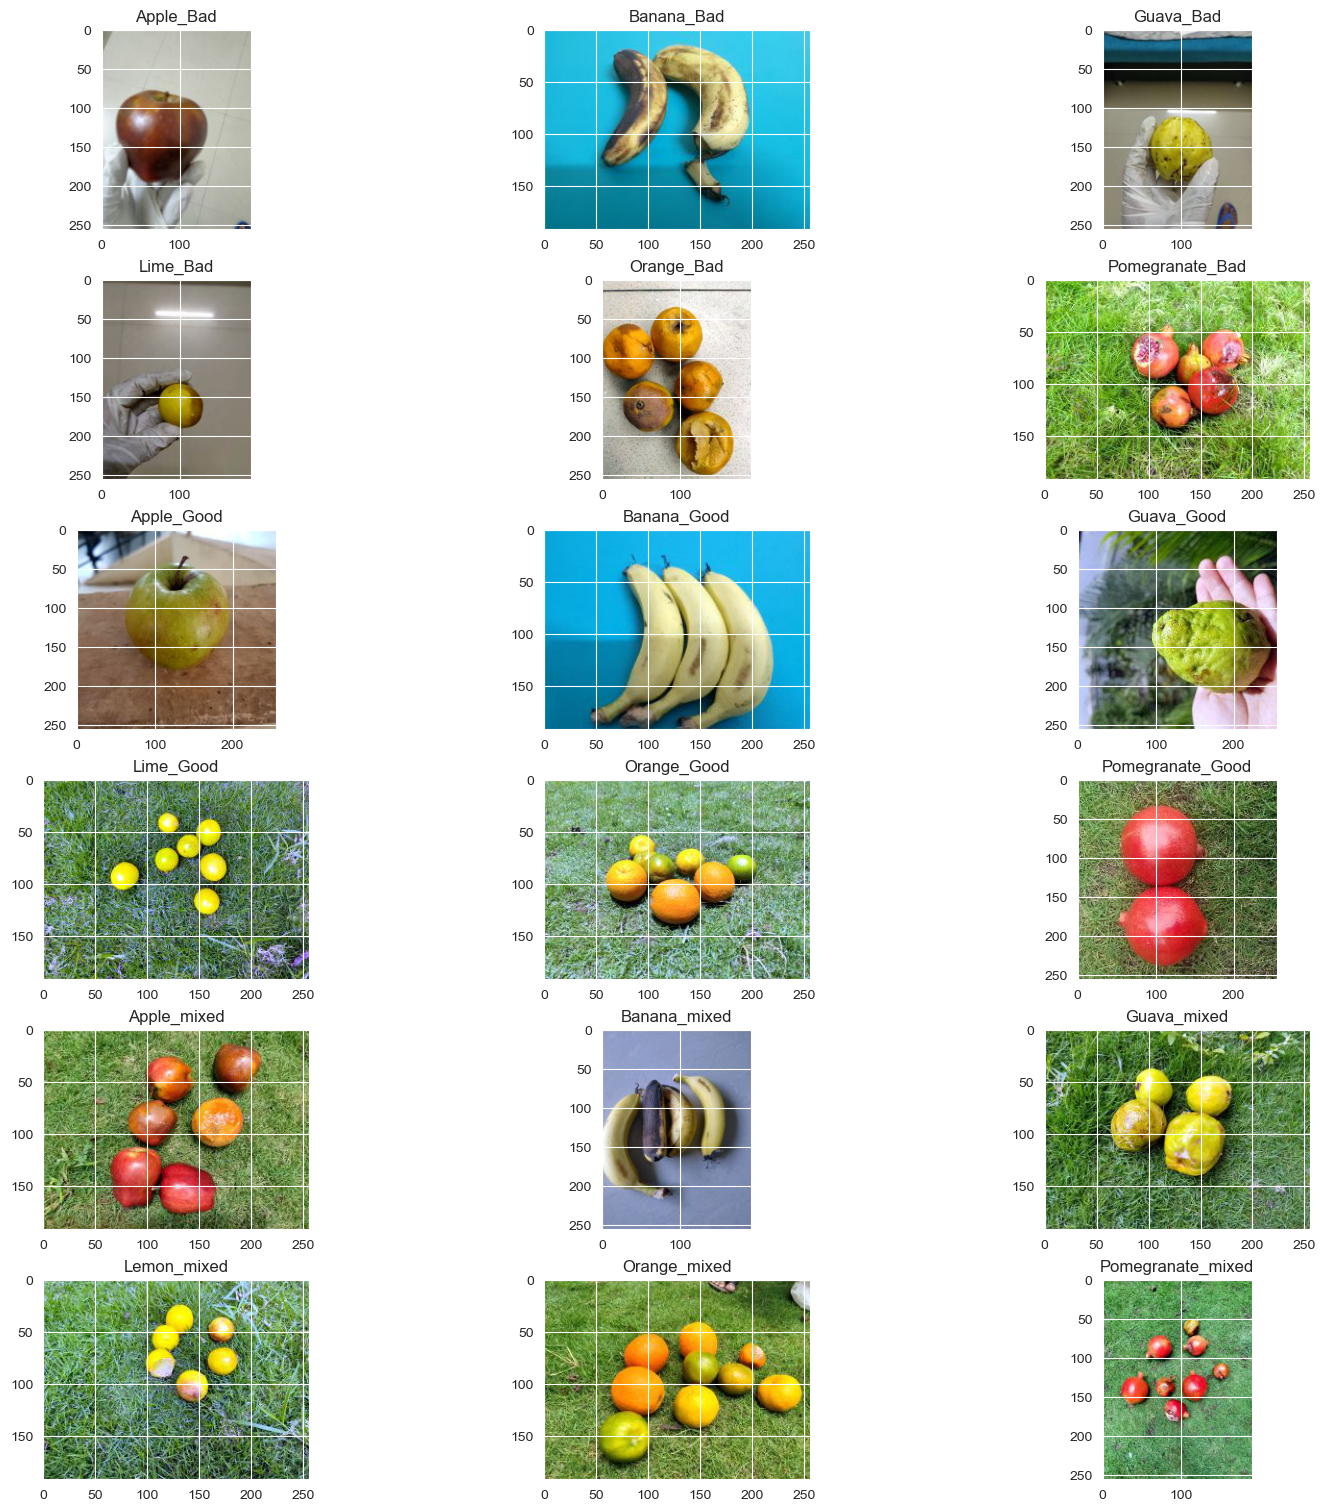

In [4]:
# Visualize sample images from different labels
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(15, 15), constrained_layout=True)
ax = ax.flatten()
j = 0
for i in df['labels'].unique():
    ax[j].imshow(plt.imread(df[df['labels'] == i].iloc[0, 0]))
    ax[j].set_title(i)
    j += 1

In [5]:
# Split the dataset into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.2, random_state=123)
print(X_train.shape)
print(X_test.shape)

# Create image data generators for training, validation, and testing
trainGen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
testGen = ImageDataGenerator(preprocessing_function=preprocess_input)

X_train_img = trainGen.flow_from_dataframe(dataframe=X_train,
                                           x_col='filepaths',
                                           y_col='labels',
                                           class_mode='categorical',
                                           subset='training',
                                           batch_size=32)

X_val_img = trainGen.flow_from_dataframe(dataframe=X_train,
                                         x_col='filepaths',
                                         y_col='labels',
                                         class_mode='categorical',
                                         subset='validation',
                                         batch_size=32)

X_test_img = testGen.flow_from_dataframe(dataframe=X_test,
                                         x_col='filepaths',
                                         y_col='labels',
                                         class_mode='categorical',
                                         batch_size=32,
                                         shuffle=False)



(15620, 2)
(3906, 2)
Found 12496 validated image filenames belonging to 18 classes.
Found 3124 validated image filenames belonging to 18 classes.
Found 3906 validated image filenames belonging to 18 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


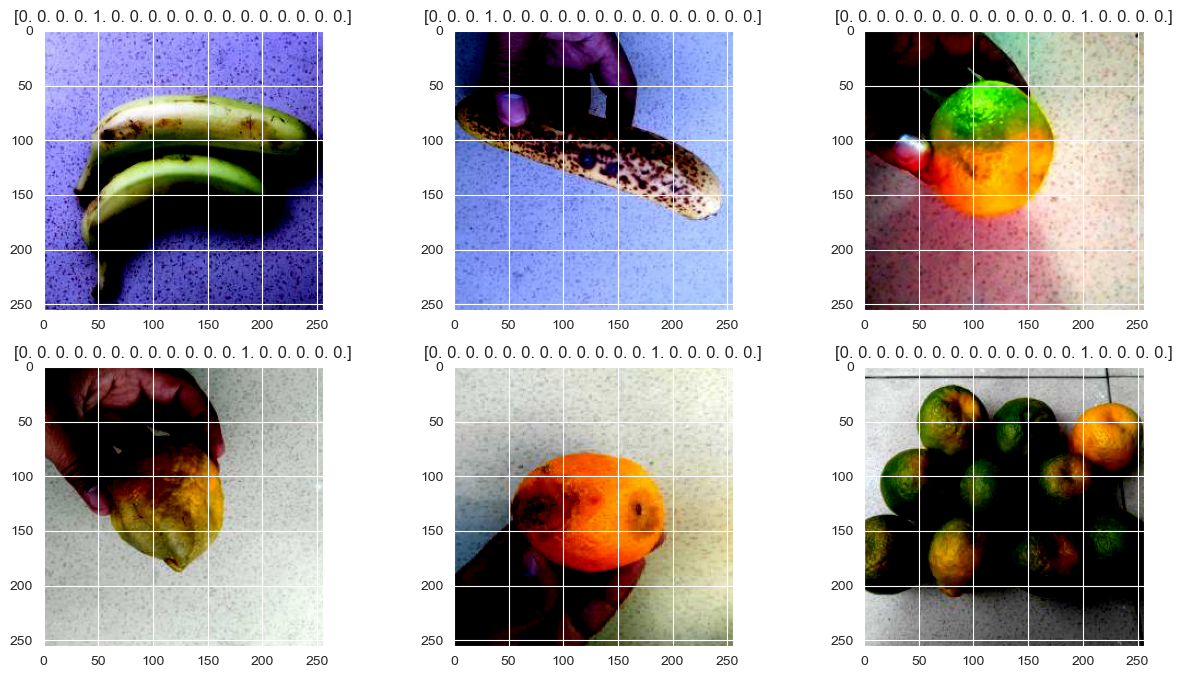

In [6]:
# Visualize sample images from the testing set
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()
j = 0
for _ in range(6):
    img, label = X_test_img.next()
    ax[j].imshow(img[0])
    ax[j].set_title(label[0])
    j += 1





In [7]:
# Create the base model using InceptionResNetV2
pre_trained = InceptionResNetV2(include_top=False, input_shape=(256, 256, 3))
pre_trained.trainable = False

# Data augmentation and model architecture
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

inputs = pre_trained.input
x = data_augmentation(inputs)
x = pre_trained(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(18, activation='softmax')(x)
model = Model(inputs=inputs, outputs=output)

# Compile the model
base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 inception_resnet_v2 (Funct  (None, 6, 6, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [8]:
# Fit the model to the training data
early_stop = EarlyStopping(monitor='val_loss', patience=1)
initial_epoch = 10
results = model.fit(X_train_img, epochs=initial_epoch,
                    validation_data=X_val_img,
                    callbacks=[early_stop])


Epoch 1/10
391/391 [==============================] - 1045s 3s/step - loss: 1.0833 - accuracy: 0.7020 - val_loss: 0.5280 - val_accuracy: 0.8531
Epoch 2/10
391/391 [==============================] - 1035s 3s/step - loss: 0.4784 - accuracy: 0.8559 - val_loss: 0.3653 - val_accuracy: 0.8918
Epoch 3/10
391/391 [==============================] - 1036s 3s/step - loss: 0.3531 - accuracy: 0.8937 - val_loss: 0.3037 - val_accuracy: 0.9062
Epoch 4/10
391/391 [==============================] - 1036s 3s/step - loss: 0.2893 - accuracy: 0.9097 - val_loss: 0.2389 - val_accuracy: 0.9238
Epoch 5/10
391/391 [==============================] - 1037s 3s/step - loss: 0.2439 - accuracy: 0.9231 - val_loss: 0.2037 - val_accuracy: 0.9347
Epoch 6/10
391/391 [==============================] - 1038s 3s/step - loss: 0.2073 - accuracy: 0.9333 - val_loss: 0.1757 - val_accuracy: 0.9424
Epoch 7/10
391/391 [==============================] - 1042s 3s/step - loss: 0.1882 - accuracy: 0.9409 - val_loss: 0.1649 - val_accuracy:

Text(0.5, 1.0, 'Loss')

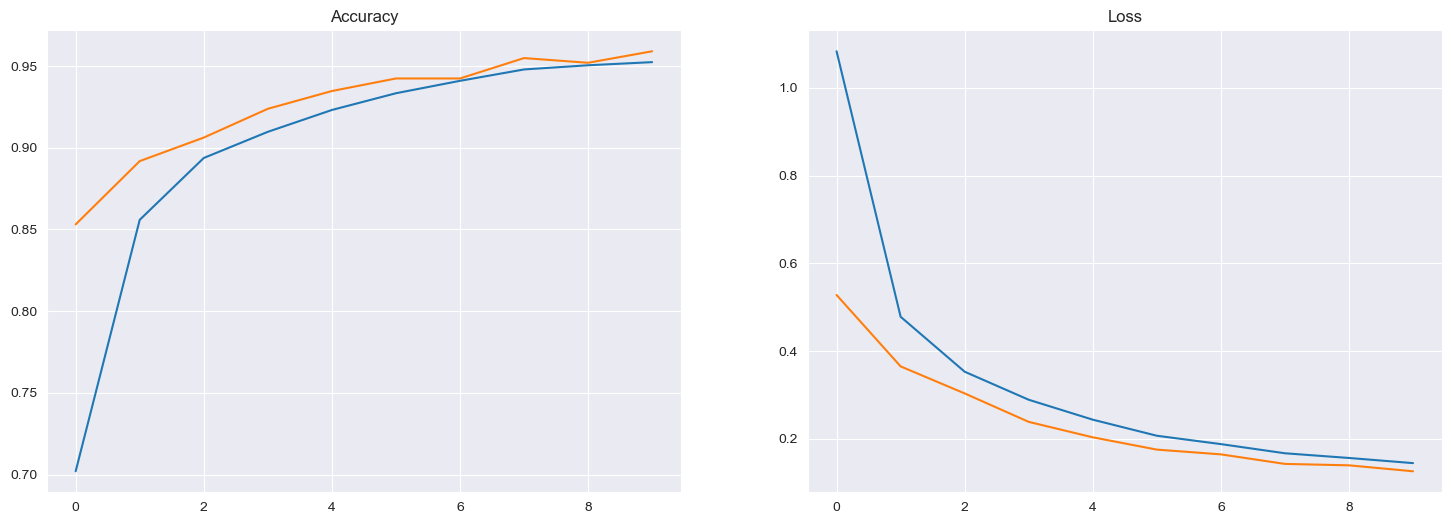

In [9]:
# Plot accuracy and loss curves
result_df = pd.DataFrame(results.history)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax = ax.flatten()
ax[0].plot(result_df[['accuracy', 'val_accuracy']])
ax[0].set_title("Accuracy")
ax[1].plot(result_df[['loss', 'val_loss']])
ax[1].set_title("Loss")



In [10]:
# Make predictions on the testing set
pred = model.predict(X_test_img)
pred = np.argmax(pred, axis=1)

pred_df = X_test.copy()
labels = {}
for l, v in X_test_img.class_indices.items():
    labels.update({v: l})
pred_df['pred'] = pred
pred_df['pred'] = pred_df['pred'].apply(lambda x: labels[x])



123/123 [==============================] - 260s 2s/step


Accuracy Score: 0.9615975422427036


<Axes: >

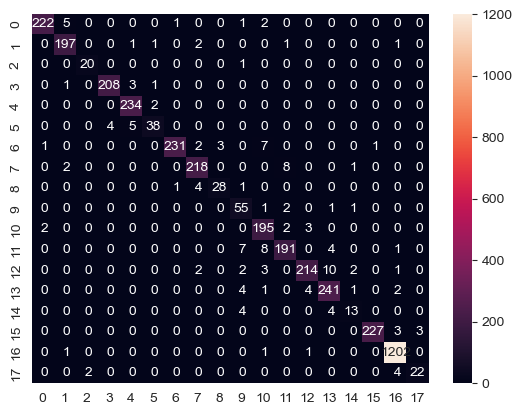

In [11]:
# Evaluate the model
print(f"Accuracy Score: {accuracy_score(pred_df['labels'], pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['labels'], pred_df['pred']), annot=True, fmt='2d')



                                               filepaths            labels  \
8323   C:\Users\ABHIJEET\Processed Images_Fruits\Good...       Banana_Good   
4204   C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...          Lime_Bad   
16867  C:\Users\ABHIJEET\Processed Images_Fruits\Good...  Pomegranate_Good   
4413   C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...          Lime_Bad   
12590  C:\Users\ABHIJEET\Processed Images_Fruits\Good...  Pomegranate_Good   
14868  C:\Users\ABHIJEET\Processed Images_Fruits\Good...  Pomegranate_Good   

                   pred  
8323        Banana_Good  
4204           Lime_Bad  
16867  Pomegranate_Good  
4413           Lime_Bad  
12590  Pomegranate_Good  
14868  Pomegranate_Good  


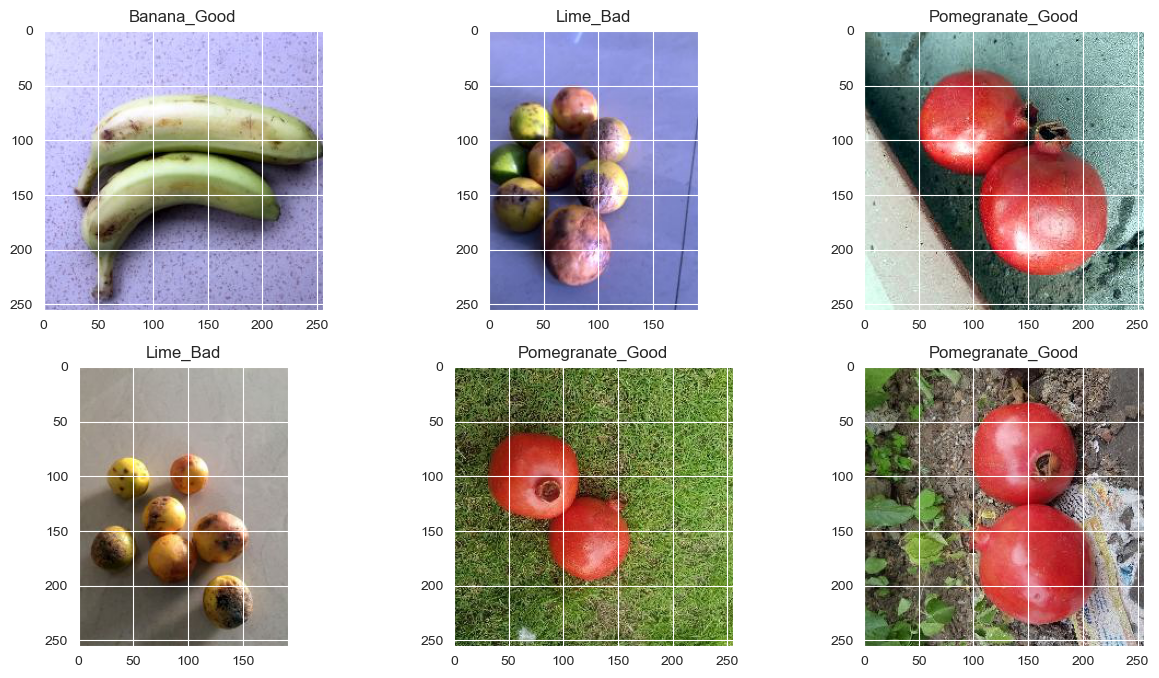

In [13]:
# Display correctly classified images
print(pred_df[pred_df['labels'] == pred_df['pred']].head(6))
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()
imlist = pred_df[pred_df['labels']== pred_df['pred']].head(6).reset_index()
for i in range(0, 6):
    ax[i].imshow(plt.imread(imlist['filepaths'][i]))
    ax[i].set_title(imlist['labels'][i])



In [15]:
# Enable fine-tuning by unfreezing the base model
pre_trained.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
fine_tune_at = 100
for layer in pre_trained.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model for fine-tuning
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=base_learning_rate / 10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, None   0         
                             )                                   
                                                                 
 inception_resnet_v2 (Funct  (None, 6, 6, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                             

In [16]:
# Fine-tune the model
fine_tune_epochs = 10
total_epochs = initial_epoch + fine_tune_epochs
history_fine = model.fit(X_train_img,
                         epochs=total_epochs,
                         initial_epoch=initial_epoch,
                         validation_data=X_val_img)



Epoch 11/20
391/391 [==============================] - 3150s 8s/step - loss: 0.0881 - accuracy: 0.9702 - val_loss: 0.0639 - val_accuracy: 0.9782
Epoch 12/20
391/391 [==============================] - 3095s 8s/step - loss: 0.0475 - accuracy: 0.9854 - val_loss: 0.0255 - val_accuracy: 0.9917
Epoch 13/20
391/391 [==============================] - 3095s 8s/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.0251 - val_accuracy: 0.9917
Epoch 14/20
391/391 [==============================] - 3124s 8s/step - loss: 0.0193 - accuracy: 0.9930 - val_loss: 0.0246 - val_accuracy: 0.9933
Epoch 15/20
391/391 [==============================] - 3129s 8s/step - loss: 0.0150 - accuracy: 0.9950 - val_loss: 0.0241 - val_accuracy: 0.9933
Epoch 16/20
391/391 [==============================] - 3111s 8s/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.0123 - val_accuracy: 0.9965
Epoch 17/20
391/391 [==============================] - 3087s 8s/step - loss: 0.0101 - accuracy: 0.9965 - val_loss: 0.0159 - val_ac

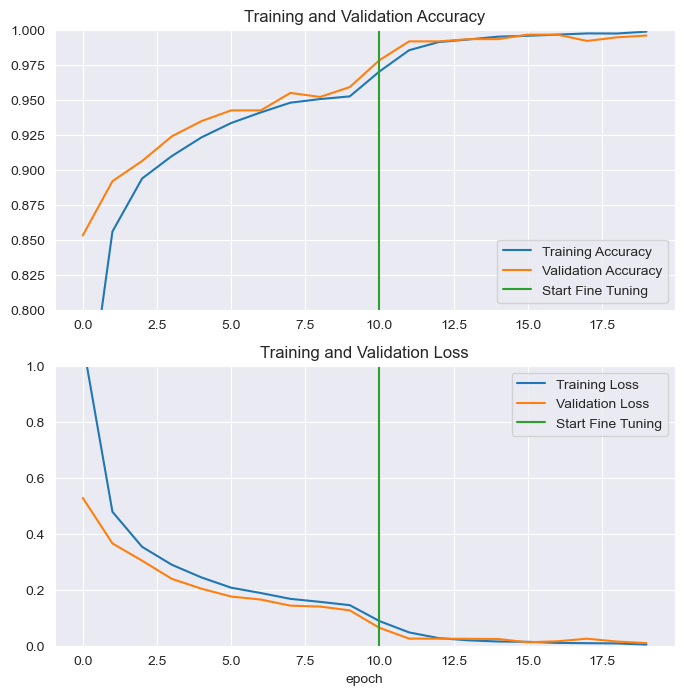

In [17]:
# Plot accuracy and loss curves after fine-tuning
acc = results.history['accuracy'] + history_fine.history['accuracy']
val_acc = results.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = results.history['loss'] + history_fine.history['loss']
val_loss = results.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epoch, initial_epoch], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epoch, initial_epoch], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [18]:
# Evaluate the fine-tuned model on the testing set
loss, accuracy = model.evaluate(X_test_img)
print('Test accuracy:', accuracy)



123/123 [==============================] - 259s 2s/step - loss: 0.0350 - accuracy: 0.9939
Test accuracy: 0.9938555955886841


In [19]:
# Make predictions using the fine-tuned model
pred = model.predict(X_test_img)
pred = np.argmax(pred, axis=1)

pred_df = X_test.copy()
labels = {}
for l, v in X_test_img.class_indices.items():
    labels.update({v: l})
pred_df['pred'] = pred
pred_df['pred'] = pred_df['pred'].apply(lambda x: labels[x])



123/123 [==============================] - 260s 2s/step


Accuracy Score: 0.9938556067588326
                                               filepaths            labels  \
8323   C:\Users\ABHIJEET\Processed Images_Fruits\Good...       Banana_Good   
4204   C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...          Lime_Bad   
16867  C:\Users\ABHIJEET\Processed Images_Fruits\Good...  Pomegranate_Good   
4413   C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...          Lime_Bad   
12590  C:\Users\ABHIJEET\Processed Images_Fruits\Good...  Pomegranate_Good   
14868  C:\Users\ABHIJEET\Processed Images_Fruits\Good...  Pomegranate_Good   
12894  C:\Users\ABHIJEET\Processed Images_Fruits\Good...  Pomegranate_Good   
4928   C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...        Orange_Bad   
2547   C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...         Guava_Bad   
6524   C:\Users\ABHIJEET\Processed Images_Fruits\Bad ...   Pomegranate_Bad   
16789  C:\Users\ABHIJEET\Processed Images_Fruits\Good...  Pomegranate_Good   
19321  C:\Users\ABHIJEET\Proc

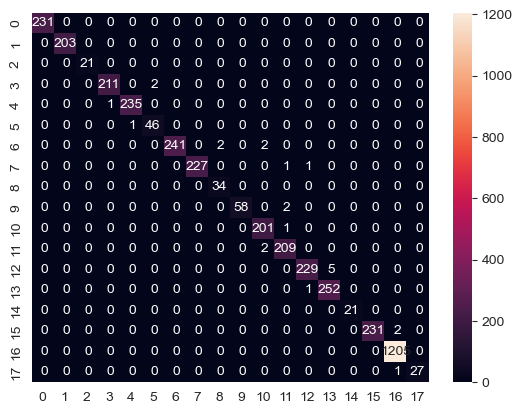

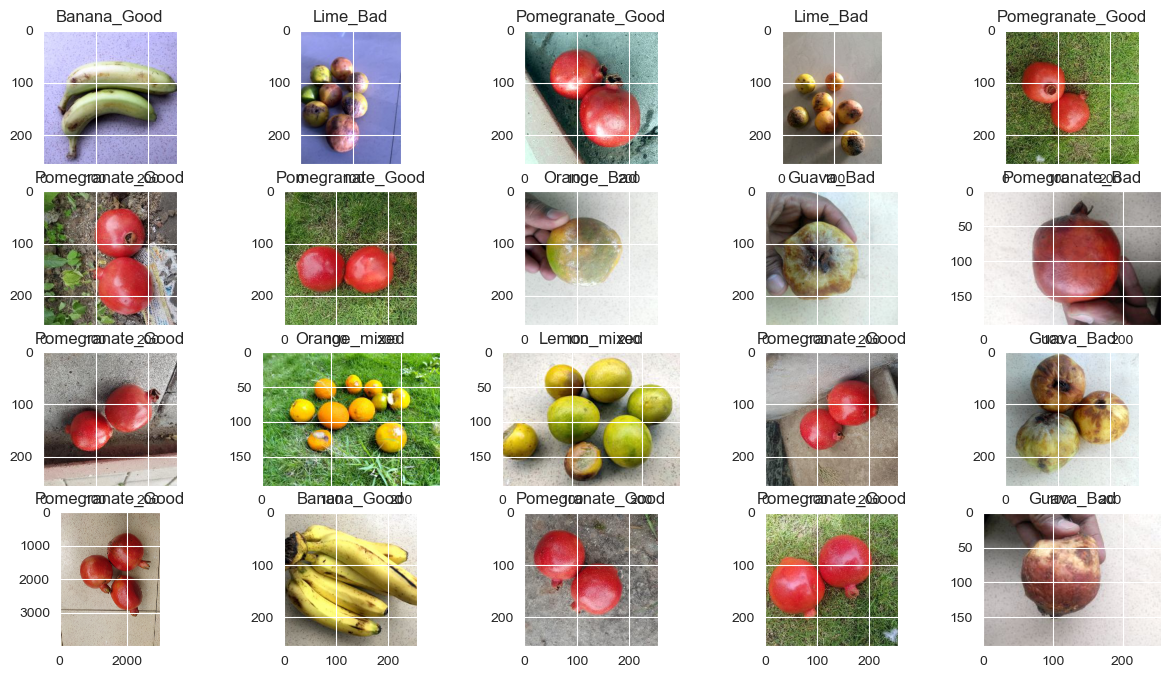

In [20]:
# Evaluate the fine-tuned model
print(f"Accuracy Score: {accuracy_score(pred_df['labels'], pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['labels'], pred_df['pred']), annot=True, fmt='2d')

# Display correctly classified images
print(pred_df[pred_df['labels'] == pred_df['pred']].head(20))
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15, 8))
ax = ax.flatten()
imlist = pred_df[pred_df['labels'] == pred_df['pred']].head(20).reset_index()
for i in range(0, 20):
    ax[i].imshow(plt.imread(imlist['filepaths'][i]))
    ax[i].set_title(imlist['labels'][i])



In [21]:
# Save the model
model.save("model_fruitNet.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model_fruitnet.tflite', 'wb') as f:
    f.write(tflite_model)